In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_test_with_iPhone = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_images_160x320.npy')
y_true_with_iPhone = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')
pred_CNN_with_iPhone = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation.npy')
pred_UNET_with_iPhone = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation.npy')

X_test_without_iPhone = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/test_images_160x320_no_iphone.npy')
y_test_without_iPhone = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/test_landmarks_no_iphone.npy')
pred_CNN_without_iPhone = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation_without_iPhone.npy')
pred_UNET_without_iPhone = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation_no_iPhone.npy')

In [4]:
print(X_test_with_iPhone.shape)
print(y_true_with_iPhone.shape)

print(pred_CNN_with_iPhone.shape)
print(pred_UNET_with_iPhone.shape)

(987, 160, 320, 3)
(987, 18, 2)
(987, 18, 2)
(987, 18, 2)


In [5]:
print(X_test_without_iPhone.shape)
print(y_test_without_iPhone.shape)

print(pred_CNN_without_iPhone.shape)
print(pred_UNET_without_iPhone.shape)

(865, 160, 320, 3)
(865, 18, 2)
(865, 18, 2)
(865, 18, 2)


evaluation boxplot

In [6]:
height, width = 160, 320

# error per image (MPE in pixel)
def landmark_error(y_true, y_pred, width, height):
    y_true_dn = y_true.copy()
    y_pred_dn = y_pred.copy()
    y_true_dn[:, :, 0] *= width
    y_true_dn[:, :, 1] *= height
    y_pred_dn[:, :, 0] *= width
    y_pred_dn[:, :, 1] *= height
    return np.sqrt(((y_true_dn - y_pred_dn)**2).sum(axis=2)).mean(axis=1)

# error arrays
errors_with_iPhone_CNN = landmark_error(y_true_with_iPhone, pred_CNN_with_iPhone, width, height)
errors_with_iPhone_UNET = landmark_error(y_true_with_iPhone, pred_UNET_with_iPhone, width, height)
errors_without_iPhone_CNN = landmark_error(y_test_without_iPhone, pred_CNN_without_iPhone, width, height)
errors_without_iPhone_UNET = landmark_error(y_test_without_iPhone, pred_UNET_without_iPhone, width, height)

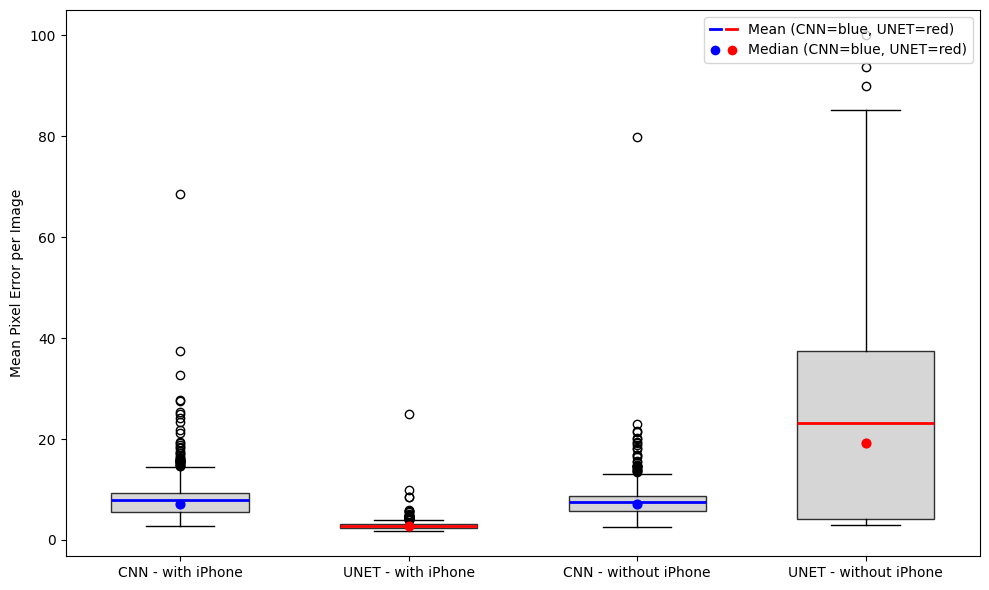

In [10]:
height, width = 160, 320
errors_list = [
    errors_with_iPhone_CNN, errors_with_iPhone_UNET,
    errors_without_iPhone_CNN, errors_without_iPhone_UNET]

labels = ['CNN - with iPhone', 'UNET - with iPhone',
          'CNN - without iPhone', 'UNET - without iPhone']

fig, ax = plt.subplots(figsize=(10,6))

# boxplot
box = ax.boxplot(errors_list, patch_artist=True, widths=0.6,
                 medianprops=dict(color='white', linewidth=0))

# box grey
for patch in box['boxes']:
    patch.set_facecolor('#CCCCCC')
    patch.set_alpha(0.8)

# color per model
colors = ['blue', 'red', 'blue', 'red']

# mean line and median dot
for i, (d, c) in enumerate(zip(errors_list, colors)):
    mean_val = np.mean(d)
    median_val = np.median(d)

    # mean
    x_left = i + 1 - 0.3
    x_right = i + 1 + 0.3
    ax.hlines(mean_val, x_left, x_right, color=c, linewidth=2)

    # median
    ax.scatter(i+1, median_val, color=c, s=40, zorder=3)

# legend
# line mean
mean_blue = Line2D([0], [0], color='blue', linewidth=2)
mean_red = Line2D([0], [0], color='red', linewidth=2)

# dot medain
median_blue = Line2D([0], [0], marker='o', color='w',markerfacecolor='blue', markersize=8)
median_red = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8)

# legend, combine cnn and unet
ax.legend(
    handles=[(mean_blue, mean_red), (median_blue, median_red)],
    labels=['Mean (CNN=blue, UNET=red)', 'Median (CNN=blue, UNET=red)'],
    handler_map={tuple: matplotlib.legend_handler.HandlerTuple(ndivide=None)},
    loc='upper right')

# axis
ax.set_xticklabels(labels)
ax.set_ylabel('Mean Pixel Error per Image')

plt.tight_layout()
plt.show()

summarize in table

In [11]:
summary = {}
for label, vals in zip(labels, errors_list):
    summary[label] = f"{np.mean(vals):.2f} ± {np.std(vals):.2f}, median: {np.median(vals):.2f}"

summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['MPE [Pixel]'])

In [12]:
summary_df.head()

,MPE [Pixel]
CNN - with iPhone,"7.94 ± 3.92, median: 7.12"
UNET - with iPhone,"2.85 ± 0.97, median: 2.69"
CNN - without iPhone,"7.61 ± 3.62, median: 7.09"
UNET - without iPhone,"23.24 ± 22.03, median: 19.30"
